In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Load the data from the MATLAB file
data = sio.loadmat('data/lm_dataset_task.mat')
x = data['x'].flatten()       # Shape (N,)
y = data['y'].flatten()       # Shape (N,)
u_init = data['u'].flatten()  # Initial u parameters
v_init = data['v'].flatten()  # Initial v parameters
s_init = data['s'].flatten()  # Initial s parameters
r_init = data['r'].flatten()  # Initial r parameters

N = len(x)
K = len(s_init)


In [3]:
# Since u_K and v_K are zero, we append zero
u_init = np.append(u_init, 0)
v_init = np.append(v_init, 0)

# Combine parameters into a single vector theta
theta_init = np.concatenate([s_init, r_init, u_init[:-1], v_init[:-1]])


In [4]:
def compute_weights(x, u, v):
    exponent = np.outer(u, x) + v[:, np.newaxis]
    # To prevent numerical overflow, subtract the max exponent
    max_exponent = np.max(exponent, axis=0)
    exponent = exponent - max_exponent
    exp_exponent = np.exp(exponent)
    denominator = np.sum(exp_exponent, axis=0)
    weights = exp_exponent / denominator
    return weights


In [5]:
def model_function(theta, x, K):
    s = theta[:K]
    r = theta[K:2*K]
    u = np.append(theta[2*K:3*K-1], 0)  # u_K = 0
    v = np.append(theta[3*K-1:], 0)     # v_K = 0

    # Compute weights
    weights = compute_weights(x, u, v)

    # Compute individual linear models
    y_hat_k = s[:, np.newaxis] * x + r[:, np.newaxis]

    # Compute the mixture
    y_hat = np.sum(weights * y_hat_k, axis=0)
    return y_hat, weights, y_hat_k


In [6]:
def compute_residuals_and_jacobian(theta, x, y, K):
    s = theta[:K]
    r = theta[K:2*K]
    u = np.append(theta[2*K:3*K-1], 0)
    v = np.append(theta[3*K-1:], 0)

    # Compute weights
    exponent = np.outer(u, x) + v[:, np.newaxis]
    max_exponent = np.max(exponent, axis=0)
    exponent = exponent - max_exponent
    exp_exponent = np.exp(exponent)
    denominator = np.sum(exp_exponent, axis=0)
    weights = exp_exponent / denominator

    # Compute y_hat_k and y_hat
    y_hat_k = s[:, np.newaxis] * x + r[:, np.newaxis]
    y_hat = np.sum(weights * y_hat_k, axis=0)

    # Residuals
    residuals = y_hat - y

    N = len(x)
    num_params = len(theta)
    J = np.zeros((N, num_params))

    # Partial derivatives w.r.t s_k and r_k
    for k in range(K):
        idx_s = k          # Index for s_k
        idx_r = K + k      # Index for r_k
        J[:, idx_s] = weights[k, :] * x
        J[:, idx_r] = weights[k, :]

    # Partial derivatives w.r.t u_j and v_j (j = 1 to K-1)
    for j in range(K-1):
        idx_u = 2*K + j        # Index for u_j
        idx_v = 3*K - 1 + j    # Index for v_j

        w_j = weights[j, :]
        y_hat_j = y_hat_k[j, :]

        diff = y_hat_j - y_hat

        # Derivative w.r.t u_j
        J[:, idx_u] = w_j * diff * x

        # Derivative w.r.t v_j
        J[:, idx_v] = w_j * diff

    return residuals, J


In [7]:
def levenberg_marquardt(x, y, theta_init, K, max_iter=5000, epsilon=1e-4, lambda_init=1):
    theta = theta_init.copy()
    lambda_lm = lambda_init
    N = len(x)
    f_values = []
    grad_norms = []

    for iteration in range(max_iter):
        # Compute residuals and Jacobian
        residuals, J = compute_residuals_and_jacobian(theta, x, y, K)

        # Compute objective function value
        f = np.sum(residuals**2)
        f_values.append(f)

        # Compute gradient and its norm
        grad = 2 * J.T @ residuals
        grad_norm = np.linalg.norm(grad)
        grad_norms.append(grad_norm)

        # Check stopping criteria
        if grad_norm < epsilon:
            print(f"Converged at iteration {iteration}")
            break

        # Compute Hessian approximation
        H = 2 * J.T @ J

        # LM update
        H_lm = H + lambda_lm * np.eye(len(theta))
        delta_theta = -np.linalg.solve(H_lm, grad)

        # Update parameters
        theta_new = theta + delta_theta

        # Compute new residuals
        residuals_new, _ = compute_residuals_and_jacobian(theta_new, x, y, K)
        f_new = np.sum(residuals_new**2)

        # Update lambda and theta based on the change in the objective function
        if f_new < f:
            # Accept the update
            theta = theta_new
            lambda_lm /= 10
        else:
            # Reject the update and increase lambda
            lambda_lm *= 10

        # Optional: Print iteration info
        # print(f"Iteration {iteration}, f = {f}, grad_norm = {grad_norm}, lambda = {lambda_lm}")

    return theta, f_values, grad_norms


In [8]:
# Run LM algorithm
theta_opt, f_values, grad_norms = levenberg_marquardt(x, y, theta_init, K)


Converged at iteration 72


In [9]:
s_opt = theta_opt[:K]
r_opt = theta_opt[K:2*K]
u_opt = np.append(theta_opt[2*K:3*K-1], 0)  # Append u_K = 0
v_opt = np.append(theta_opt[3*K-1:], 0)     # Append v_K = 0

# Print the optimized parameters
print("Optimized s:", s_opt)
print("Optimized r:", r_opt)
print("Optimized u:", u_opt)
print("Optimized v:", v_opt)


Optimized s: [12.12569911  3.26548685 -3.99969186 -1.20154989]
Optimized r: [-2.65323345 23.05884085 19.87664058 -0.07695811]
Optimized u: [  13.07807368 -232.96822911 1378.89543372    0.        ]
Optimized v: [ 2.34625241e+00 -1.43567959e+03 -2.89259143e+03  0.00000000e+00]


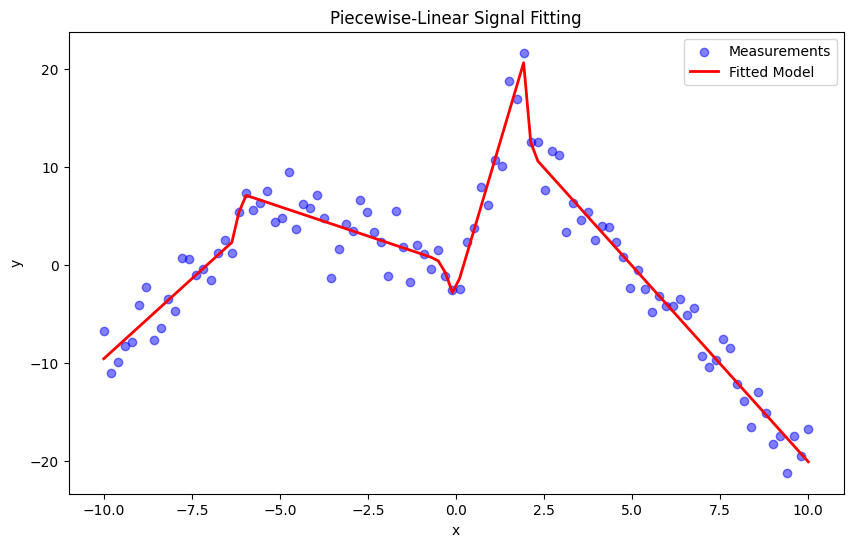

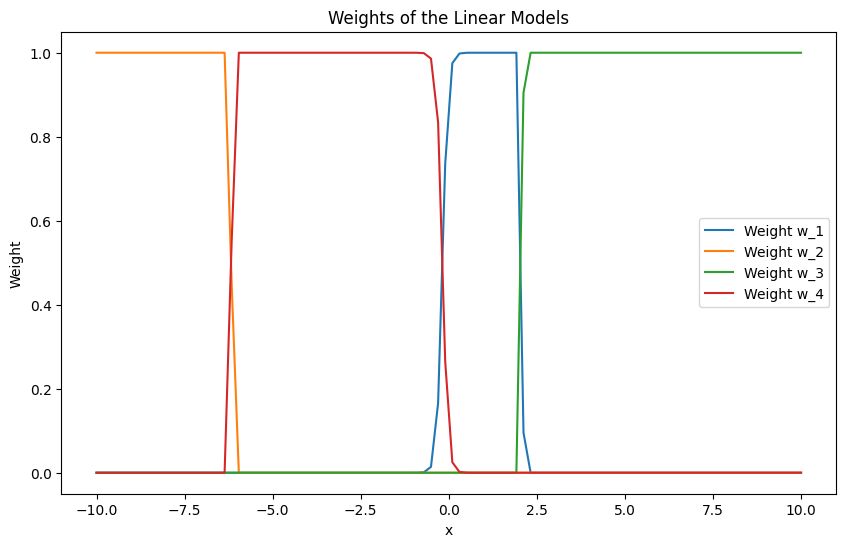

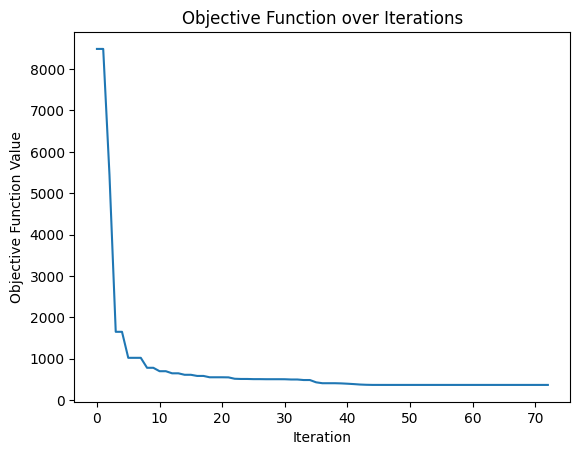

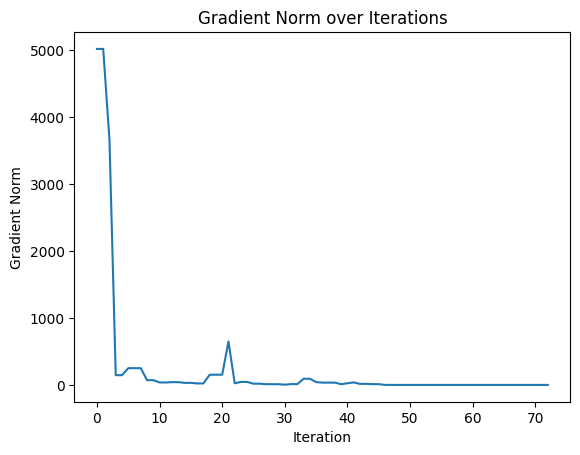

In [10]:
# Compute the fitted model and weights
y_hat, weights, y_hat_k = model_function(theta_opt, x, K)

# Sort x and corresponding arrays for better plotting
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
y_hat_sorted = y_hat[sorted_indices]
weights_sorted = weights[:, sorted_indices]

# Plot the measurements and fitted model
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Measurements', color='blue', alpha=0.5)
plt.plot(x_sorted, y_hat_sorted, color='red', label='Fitted Model', linewidth=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Piecewise-Linear Signal Fitting')
plt.show()

# Plot the weights
plt.figure(figsize=(10, 6))
for k in range(K):
    plt.plot(x_sorted, weights_sorted[k, :], label=f'Weight w_{k+1}')
plt.legend()
plt.xlabel('x')
plt.ylabel('Weight')
plt.title('Weights of the Linear Models')
plt.show()

# Plot the objective function over iterations
plt.figure()
plt.plot(f_values)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Objective Function over Iterations')
plt.show()

# Plot the gradient norm over iterations
plt.figure()
plt.plot(grad_norms)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm over Iterations')
plt.show()
